In [35]:
import scipy.io as sio
from scipy.stats import mode
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

np.random.seed(42)

mat_content = sio.loadmat('assets/face.mat')
mat_content # Let's see the content...

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Sat May 27 02:07:24 2006',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[106, 130, 191, ...,  70, 183,  77],
        [103, 129, 185, ...,  62, 250,  72],
        [103, 130, 174, ...,  83, 163,  68],
        ...,
        [ 37,  40,  22, ...,  87, 102,  93],
        [ 36,  36,  19, ...,  89,  95, 103],
        [ 41,  35,  17, ...,  94, 106, 110]], dtype=uint8),
 'l': array([[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,
          4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,
          5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12,
         12, 12, 12, 12, 12, 12, 12, 12, 13,

In [3]:
# train, test data split

face_data = mat_content['X']
face_labels = mat_content['l']

x_train = []
x_test = []

y_train = []
y_test = []

n_classes = 52
images_per_class = 10

for i in range(n_classes):
    start_idx = i * images_per_class
    end_idx = start_idx + images_per_class
    
    x_train.append(face_data[:, start_idx:start_idx+8])
    x_test.append(face_data[:, start_idx+8:end_idx])

    y_train.append(face_labels[:, start_idx:start_idx+8])
    y_test.append(face_labels[:, start_idx+8:end_idx])

x_train = np.hstack(x_train)
x_test = np.hstack(x_test)
y_train = np.hstack(y_train)
y_test = np.hstack(y_test)



# Output the shapes of the training and testing sets
print(f"Training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")

Training set shape: (2576, 416)
Test set shape: (2576, 104)


In [4]:
x_train = x_train.astype(np.float64)
x_test = x_test.astype(np.float64)

**PCA-LDA**

In [4]:
# 클래스별로 x_train을 쪼개는 함수

def split_by_class(x_train, y_train):
    y_train = y_train.flatten()
    classes = np.unique(y_train)  # 고유 클래스 값들
    class_dict = {}
    
    for cls in classes:
        # 해당 클래스에 해당하는 인덱스 필터링
        indices = np.where(y_train == cls)[0]
        # 클래스별 x_train 데이터를 딕셔너리에 저장
        class_dict[cls] = x_train[:, indices]
    
    return class_dict

# 클래스별로 분리된 x_train
class_split_x_train = split_by_class(x_train, y_train)
class_split_x_train = np.array(list(class_split_x_train.values()))

In [5]:
# compute the mean vector

class_mean = np.mean(class_split_x_train, axis=2) #(52,2576)
overall_mean = np.mean(x_train, axis=1).reshape(-1,1) #(2576, 1)

In [6]:
# within-class scatter matrix, between-class scatter matrix, total scatter matrix

n_features = x_train.shape[0]
Sb = np.zeros((n_features, n_features))
Sw = np.zeros((n_features, n_features))

# total scatter matrix
T = x_train - overall_mean
St = np.matmul(T, T.T) / (T.shape[1]-1)

for i in range(class_split_x_train.shape[2]):
    X = class_split_x_train[i]
    N = X.shape[1]
    
    # between-class scatter matrix
    mean_diff = class_mean[i].reshape(-1, 1) - overall_mean #(2576, 1)
    Sb += N * (mean_diff).dot(mean_diff.T)
    
    # within-class scatter matrix
    for j in range(X.shape[1]):
        x = X[:, j]
        x = x.reshape(n_features, 1)
        mean = class_mean[i].reshape(n_features, 1)
        Sw += (x - mean).dot((x - mean).T)

In [7]:
#################################
# ranks of the scatter matrices #
#################################

# between-class scatter matrix
rank_b = np.linalg.matrix_rank(Sb)
print('rank of between-class scatter matrix: ', rank_b)

# within-class scatter matrix
rank_w = np.linalg.matrix_rank(Sw)
print('rank of within-class scatter matrix: ', rank_w)

# total scatter matrix
rank_t = np.linalg.matrix_rank(St)
print('rank of total scatter matrix: ', rank_t)

rank of between-class scatter matrix:  8
rank of within-class scatter matrix:  56
rank of total scatter matrix:  415


In [8]:
# PCA
M_pca = 100

eigvals, eigvecs = np.linalg.eigh(St)

sorted_indices = np.argsort(eigvals)[::-1]

eigvals = eigvals[sorted_indices] #(2576,)
eigvecs = eigvecs[:, sorted_indices] #(2576, 2576)

W_pca = eigvecs[:, :M_pca] #(2576, M_pca)
A_pca = np.matmul(W_pca.T, T) #(M_pca, 416)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


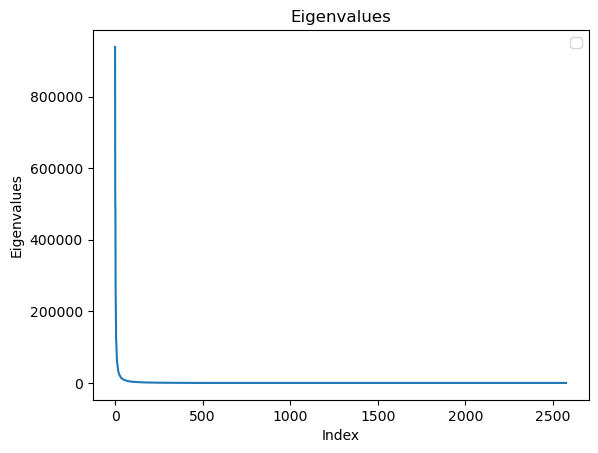

In [9]:
# Plot the arrays
plt.plot(eigvals)

# Add title and labels
plt.title("Eigenvalues")
plt.xlabel("Index")
plt.ylabel("Eigenvalues")

# Add a legend to distinguish the arrays
plt.legend()

# Show the plot
plt.show()

In [10]:
# LDA
M_lda = 51

S_lda = np.linalg.inv(W_pca.T @ Sw @ W_pca) @ (W_pca.T @ Sb @ W_pca)

eigvals, eigvecs = np.linalg.eigh(S_lda)

sorted_indices = np.argsort(eigvals)[::-1]

eigvals = eigvals[sorted_indices] #(M_pca,)
eigvecs = eigvecs[:, sorted_indices] #(M_pca, M_pca)

W_lda = eigvecs[:, :M_lda] #(M_pca, M_lda)

W_opt = np.matmul(W_pca, W_lda) #(2576, M_lda)
A = np.matmul(W_opt.T, T) #(M_lda, 416)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


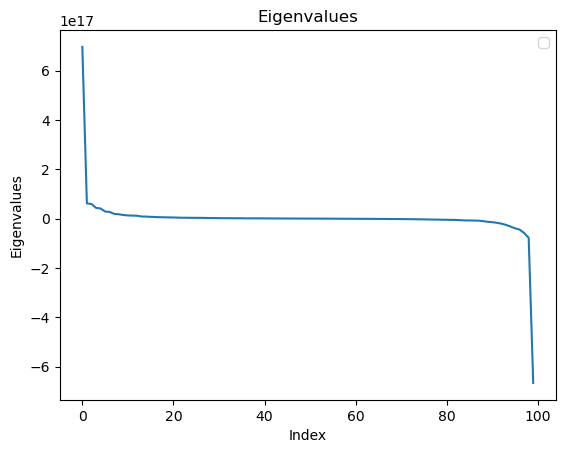

In [11]:
# Plot the arrays
plt.plot(eigvals)

# Add title and labels
plt.title("Eigenvalues")
plt.xlabel("Index")
plt.ylabel("Eigenvalues")

# Add a legend to distinguish the arrays
plt.legend()

# Show the plot
plt.show()

In [12]:
# Reconstruction

# train
x_train_rec = overall_mean + np.matmul(W_opt, A) #(2576, 416)

# test
T_test = x_test - overall_mean
A_test = np.matmul(W_opt.T, T_test) #(M_lda, 104)
x_test_rec = overall_mean + np.matmul(W_opt, A_test) #(2576, 104)

rec_err_train = np.mean(np.abs(x_train - x_train_rec))
print(f"Train Reconstruction Error: {rec_err_train}")

rec_err_test = np.mean(np.abs(x_test - x_test_rec))
print(f"Test Reconstruction Error: {rec_err_test}")

Train Reconstruction Error: 22.88608977502502
Test Reconstruction Error: 23.059603197031617


**PCA-LDA based face recognition with the NN classifier**

In [7]:
class LDA:
    def __init__(self, M_pca=40, M_lda=20):
        self.M_pca = M_pca
        self.M_lda = M_lda
    
    def split_by_class(self, x_train, y_train):
        y_train = y_train.flatten()
        classes = np.unique(y_train)  # 고유 클래스 값들
        class_dict = {}
        
        for cls in classes:
            # 해당 클래스에 해당하는 인덱스 필터링
            indices = np.where(y_train == cls)[0]
            # 클래스별 x_train 데이터를 딕셔너리에 저장
            class_dict[cls] = x_train[:, indices]
        
        return class_dict

    def scatter_matrix_calculation(self, x_train, y_train):
        class_split_x_train = self.split_by_class(x_train, y_train)
        class_split_x_train = np.array(list(class_split_x_train.values()))
            
        class_mean = np.mean(class_split_x_train, axis=2) #(52,2576)
        self.overall_mean = np.mean(x_train, axis=1).reshape(-1,1) #(2576, 1)

        n_features = x_train.shape[0]
        Sb = np.zeros((n_features, n_features))
        Sw = np.zeros((n_features, n_features))

        # total scatter matrix
        T = x_train - self.overall_mean
        St = np.matmul(T, T.T) / (T.shape[1]-1)

        for i in range(class_split_x_train.shape[2]):
            X = class_split_x_train[i]
            N = X.shape[1]
                
            # between-class scatter matrix
            mean_diff = class_mean[i].reshape(-1, 1) - self.overall_mean #(2576, 1)
            Sb += N * (mean_diff).dot(mean_diff.T)
            # within-class scatter matrix
            for j in range(X.shape[1]):
                x = X[:, j]
                x = x.reshape(n_features, 1)
                mean = class_mean[i].reshape(n_features, 1)
                Sw += (x - mean).dot((x - mean).T)
                
        return St, Sw, Sb
    
    def fit(self, x_train, y_train):
        # PCA
        St, Sw, Sb = self.scatter_matrix_calculation(x_train, y_train)
        
        eigvals, eigvecs = np.linalg.eigh(St)
        sorted_indices = np.argsort(eigvals)[::-1]
        eigvals = eigvals[sorted_indices] #(2576,)
        eigvecs = eigvecs[:, sorted_indices] #(2576, 2576)
        W_pca = eigvecs[:, :self.M_pca] #(2576, M_pca)

        # LDA
        S_lda = np.linalg.inv(W_pca.T @ Sw @ W_pca) @ (W_pca.T @ Sb @ W_pca)
        eigvals, eigvecs = np.linalg.eigh(S_lda)
        sorted_indices = np.argsort(eigvals)[::-1]
        eigvals = eigvals[sorted_indices] #(M_pca,)
        eigvecs = eigvecs[:, sorted_indices] #(M_pca, M_pca)
        W_lda = eigvecs[:, :self.M_lda] #(M_pca, M_lda)
        self.W_opt = np.matmul(W_pca, W_lda) #(2576, M_lda)

        x_train_proj = np.matmul(self.W_opt.T, x_train - self.overall_mean)
        self.clf = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
        self.clf.fit(x_train_proj.T, y_train.T)

    def predict(self, x_test):
        x_test_proj = np.matmul(self.W_opt.T, x_test - self.overall_mean)
        self.predictions = self.clf.predict(x_test_proj.T)
    
    def evaluate(self, y_test):
        # recognition accuracy
        accuracy = accuracy_score(y_test.T, self.predictions)        
        return accuracy
    
    def confusion(self, y_test):
        cm = confusion_matrix(y_test.T, self.predictions)
        # Confusion matrix 시각화
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()
        
    def reconstruction(self, x_test, plot=True, indices=[0, 1, 2]):
        x_test_centered = x_test - self.overall_mean
        x_test_proj = np.matmul(self.W_opt.T, x_test_centered) #(M_lda, 104)
        x_test_rec = self.overall_mean + np.matmul(self.W_opt, x_test_proj)
        rec_err = np.mean((x_test - x_test_rec) ** 2)
        print(f"Reconstruction Error: {rec_err}")
        
        if plot==True:
            # indices length >= 2
            plt.figure()
            f, ax = plt.subplots(1, len(indices))
            for i, idx in enumerate(indices):
                img = np.reshape(x_test_rec[:,idx],(46,56)).T
                ax[i].imshow(img, cmap = 'gist_gray')

In [ ]:
M_pca_ = [10, 30, 50, 100, 200, 364] # <= N-c = 416-52= 364
M_lda_ = [5, 10, 20, 30, 40, 51] # <= c-1 = 52-1 = 51
acc_results = []
for M_pca in M_pca_:
    for M_lda in M_lda_:
        if M_pca >= M_lda:
            lda = LDA(M_pca=M_pca, M_lda=M_lda)
            lda.fit(x_train, y_train)
            lda.predict(x_test)
            # Calculate Accuracy
            accuracy = lda.evaluate(y_test)
            print(f"M_pca: {M_pca}, M_lda: {M_lda}, Accuracy: {accuracy * 100:.2f}%")
            acc_results.append([M_pca, M_lda, accuracy])
            
acc_results = np.array(acc_results).T

c:\Users\user\anaconda3\envs\env2\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


M_pca: 10, M_lda: 5, Accuracy: 35.58%


c:\Users\user\anaconda3\envs\env2\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


M_pca: 10, M_lda: 10, Accuracy: 47.12%


c:\Users\user\anaconda3\envs\env2\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


M_pca: 30, M_lda: 5, Accuracy: 27.88%


c:\Users\user\anaconda3\envs\env2\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


M_pca: 30, M_lda: 10, Accuracy: 43.27%


c:\Users\user\anaconda3\envs\env2\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


M_pca: 30, M_lda: 20, Accuracy: 53.85%


c:\Users\user\anaconda3\envs\env2\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


M_pca: 30, M_lda: 30, Accuracy: 59.62%


c:\Users\user\anaconda3\envs\env2\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


M_pca: 50, M_lda: 5, Accuracy: 30.77%


c:\Users\user\anaconda3\envs\env2\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


M_pca: 50, M_lda: 10, Accuracy: 45.19%


c:\Users\user\anaconda3\envs\env2\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


M_pca: 50, M_lda: 20, Accuracy: 50.96%


c:\Users\user\anaconda3\envs\env2\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


M_pca: 50, M_lda: 30, Accuracy: 59.62%


c:\Users\user\anaconda3\envs\env2\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


M_pca: 50, M_lda: 40, Accuracy: 59.62%


c:\Users\user\anaconda3\envs\env2\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


M_pca: 100, M_lda: 5, Accuracy: 31.73%


c:\Users\user\anaconda3\envs\env2\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


M_pca: 100, M_lda: 10, Accuracy: 43.27%


c:\Users\user\anaconda3\envs\env2\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


M_pca: 100, M_lda: 20, Accuracy: 51.92%


c:\Users\user\anaconda3\envs\env2\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


M_pca: 100, M_lda: 30, Accuracy: 52.88%


c:\Users\user\anaconda3\envs\env2\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


M_pca: 100, M_lda: 40, Accuracy: 56.73%


c:\Users\user\anaconda3\envs\env2\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


M_pca: 100, M_lda: 51, Accuracy: 57.69%


c:\Users\user\anaconda3\envs\env2\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


M_pca: 200, M_lda: 5, Accuracy: 28.85%


c:\Users\user\anaconda3\envs\env2\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


M_pca: 200, M_lda: 10, Accuracy: 46.15%


c:\Users\user\anaconda3\envs\env2\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


M_pca: 200, M_lda: 20, Accuracy: 48.08%


c:\Users\user\anaconda3\envs\env2\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


M_pca: 200, M_lda: 30, Accuracy: 50.96%


c:\Users\user\anaconda3\envs\env2\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


M_pca: 200, M_lda: 40, Accuracy: 58.65%


c:\Users\user\anaconda3\envs\env2\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


M_pca: 200, M_lda: 51, Accuracy: 59.62%


c:\Users\user\anaconda3\envs\env2\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


M_pca: 364, M_lda: 5, Accuracy: 30.77%


c:\Users\user\anaconda3\envs\env2\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


M_pca: 364, M_lda: 10, Accuracy: 37.50%


c:\Users\user\anaconda3\envs\env2\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


M_pca: 364, M_lda: 20, Accuracy: 45.19%


c:\Users\user\anaconda3\envs\env2\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


M_pca: 364, M_lda: 30, Accuracy: 50.96%


c:\Users\user\anaconda3\envs\env2\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


M_pca: 364, M_lda: 40, Accuracy: 49.04%
M_pca: 364, M_lda: 51, Accuracy: 54.81%


c:\Users\user\anaconda3\envs\env2\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


AttributeError: 'list' object has no attribute 'T'

C:\Users\user\AppData\Local\Temp\ipykernel_4148\2023821432.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = df.pivot("M_pca", "M_lda", "Accuracy")


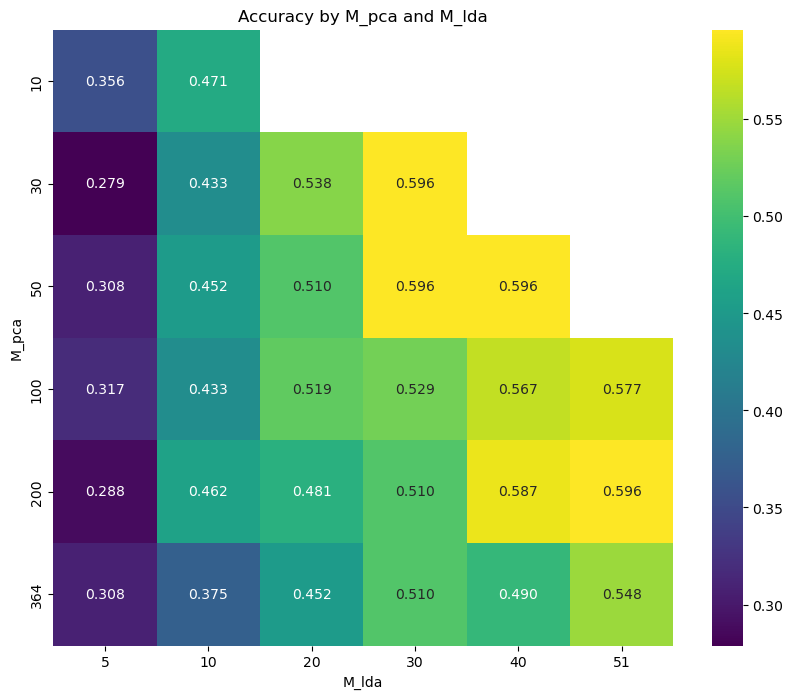

In [45]:
# M_pca, M_lda에 따른 recognition accuracy
df = pd.DataFrame({
    'M_pca': acc_results[0].astype(int),
    'M_lda': acc_results[1].astype(int),
    'Accuracy': acc_results[2]
})
heatmap_data = df.pivot("M_pca", "M_lda", "Accuracy")

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="viridis", fmt=".3f")
plt.title("Accuracy by M_pca and M_lda")
plt.show()

Reconstruction Error: 1102.362297198451


<Figure size 640x480 with 0 Axes>

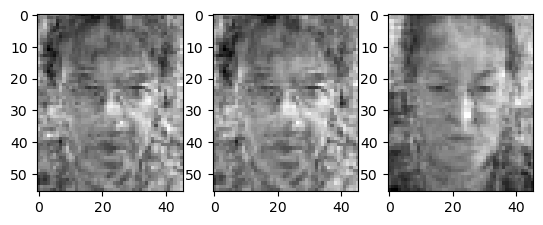

In [43]:
lda.reconstruction(x_test)

**Ensemble Learning**

randomisation in feature space 

M0 개의 largest eigenvector<br/>
M1 개의 random eigenvector (nonzero)

In [46]:
class LDA_random_feature(LDA):
    def __init__(self, M0=30, M1=30, M_lda=30, t=4, k=1, fusion='majority'):
        self.M0 = M0
        self.M1 = M1
        self.M_lda = M_lda
        self.t = t
        self.k = k
        self.fusion = fusion
        self.W_opts = []
        self.clfs = []

    
    def fit(self, x_train, y_train):
        St, Sw, Sb = super().scatter_matrix_calculation(x_train, y_train)

        # PCA
        eigvals, eigvecs = np.linalg.eigh(St)
        nonzero = eigvals>=0.00001
        eigvals = eigvals[nonzero]
        eigvecs = eigvecs[:, nonzero]
        sorted_indices = np.argsort(eigvals)[::-1]
        
        # random feature selection & LDA
        for t in range(self.t):
            indices = np.concatenate((sorted_indices[:self.M0], np.random.choice(sorted_indices[self.M0:], self.M1, replace=False)))
            W_pca = eigvecs[:, indices] #(2576, M0+M1)
            # LDA
            S_lda = np.linalg.inv(W_pca.T @ Sw @ W_pca) @ (W_pca.T @ Sb @ W_pca)
            
            eigvals_lda, eigvecs_lda = np.linalg.eigh(S_lda)
            sorted_indices_lda = np.argsort(eigvals_lda)[::-1]
            eigvals_lda = eigvals_lda[sorted_indices_lda] #(M_pca,)
            eigvecs_lda = eigvecs_lda[:, sorted_indices_lda] #(M_pca, M_pca)
            W_lda = eigvecs_lda[:, :self.M_lda] #(M_pca, M_lda)
            W_opt = np.matmul(W_pca, W_lda) #(2576, M_lda)
            self.W_opts.append(W_opt)

        for t in range(self.t):
            clf = KNeighborsClassifier(n_neighbors=self.k, metric='manhattan')

            W_opt = self.W_opts[t]
            # projection of training images
            x_train_proj = np.matmul(W_opt.T, x_train - self.overall_mean)
            clf.fit(x_train_proj.T, y_train.reshape(-1))
            self.clfs.append(clf)
            
    def predict(self, x_test):
        x_test_proj = []
        
        for t in range(self.t):
            x_test_proj.append(np.matmul(self.W_opts[t].T, x_test - self.overall_mean))
        self.pred_indiv = np.array([clf.predict(x_test_proj[t].T) for t, clf in enumerate(self.clfs)])
        
        if self.fusion == 'majority':
            preds = np.array([clf.predict(x_test_proj[t].T) for t, clf in enumerate(self.clfs)])
            self.predictions = mode(preds, axis=0).mode[0]

        if self.fusion == 'sum':
            preds = np.array([clf.predict_proba(x_test_proj[t].T) for t, clf in enumerate(self.clfs)])
            self.predictions = np.argmax(np.mean(preds, axis=0), axis=1) + 1

        if self.fusion == 'product':
            epsilon = 1e-10
            log_probs = np.array([np.log(np.maximum(clf.predict_proba(x_test_proj[t].T), epsilon)) for t, clf in enumerate(self.clfs)])
            final_probs = np.exp(np.sum(log_probs, axis=0))
            final_probs /= final_probs.sum(axis=1, keepdims=True)
            self.predictions = np.argmax(final_probs, axis=1) + 1

    def evaluate(self, y_test):
        # recognition accuracy
        acc_indiv = np.mean([accuracy_score(y_test.T, self.pred_indiv[t]) for t in range(self.t)])
        accuracy = accuracy_score(y_test.T, self.predictions)
        
        print(f"Individual Test Accuracy: {acc_indiv * 100:.2f}%")
        print(f"Final Test Accuracy: {accuracy * 100:.2f}%")
        
        return acc_indiv, accuracy

In [47]:
lda_ensemble = LDA_random_feature(fusion='majority')
lda_ensemble.fit(x_train, y_train)
print(lda_ensemble.predict(x_test))
lda_ensemble.evaluate(y_test)

lda_ensemble = LDA_random_feature(fusion='sum')
lda_ensemble.fit(x_train, y_train)
print(lda_ensemble.predict(x_test))
lda_ensemble.evaluate(y_test)

lda_ensemble = LDA_random_feature(fusion='product')
lda_ensemble.fit(x_train, y_train)
print(lda_ensemble.predict(x_test))
lda_ensemble.evaluate(y_test)

C:\Users\user\AppData\Local\Temp\ipykernel_4148\2544949987.py:56: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self.predictions = mode(preds, axis=0).mode[0]


None
Individual Test Accuracy: 50.24%
Final Test Accuracy: 56.73%
None
Individual Test Accuracy: 52.64%
Final Test Accuracy: 62.50%
None
Individual Test Accuracy: 55.05%
Final Test Accuracy: 64.42%


(0.5504807692307693, 0.6442307692307693)

Bagging<br/>
randomisation on data samples

데이터 쪼개고 나머진 안 건드려서 knn model 만들기

In [18]:
class LDA_bagging(LDA):
    def __init__(self, M_pca=40, M_lda=20, n_dataset=4, n_samples=200, k=1, fusion='majority'):
        self.M_pca = M_pca
        self.M_lda = M_lda
        self.n_dataset = n_dataset
        self.n_samples = n_samples
        self.k = k
        self.fusion = fusion
        self.clfs = []
    
    def bagging(self, x_train, y_train):
        x_bagging = []
        y_bagging = []
            
        for t in range(self.n_dataset):
            sss = StratifiedShuffleSplit(n_splits=1, train_size=self.n_samples, random_state=t)
            # StratifiedShuffleSplit으로 샘플링
            for train_idx, _ in sss.split(x_train.T, y_train.T):
                x_resampled = x_train[:, train_idx]
                y_resampled = y_train[:, train_idx]
            x_bagging.append(x_resampled)
            y_bagging.append(y_resampled)
            
        x_bagging = np.array(x_bagging) #(n_dataset, 415, n_samples)
        y_bagging = np.array(y_bagging) #(n_dataset, 1, n_samples)
            
        return x_bagging, y_bagging
        
    def fit(self, x_train, y_train):
        St, Sw, Sb = super().scatter_matrix_calculation(x_train, y_train)
        
        # PCA
        eigvals, eigvecs = np.linalg.eigh(St)
        sorted_indices = np.argsort(eigvals)[::-1]
        eigvals = eigvals[sorted_indices] #(2576,)
        eigvecs = eigvecs[:, sorted_indices] #(2576, 2576)
        W_pca = eigvecs[:, :self.M_pca]
        
        # LDA
        S_lda = np.linalg.inv(W_pca.T @ Sw @ W_pca) @ (W_pca.T @ Sb @ W_pca)
        eigvals_lda, eigvecs_lda = np.linalg.eigh(S_lda)
        sorted_indices_lda = np.argsort(eigvals_lda)[::-1]
        eigvals_lda = eigvals_lda[sorted_indices_lda] #(M_pca,)
        eigvecs_lda = eigvecs_lda[:, sorted_indices_lda] #(M_pca, M_pca)
        W_lda = eigvecs_lda[:, :self.M_lda] #(M_pca, M_lda)
        self.W_opt = np.matmul(W_pca, W_lda)
        
        # bagging
        x_train_proj = np.matmul(self.W_opt.T, x_train - self.overall_mean)
        x_bagging, y_bagging = self.bagging(x_train_proj, y_train)

        for t in range(self.n_dataset):
            clf = KNeighborsClassifier(n_neighbors=self.k, metric='manhattan')
            clf.fit(x_bagging[t].T, y_bagging[t].T)
            self.clfs.append(clf)
            
    def predict(self, x_test):
        x_test_proj = np.matmul(self.W_opt.T, x_test - self.overall_mean)
        
        # the predictions of individual models
        self.pred_indiv = np.array([clf.predict(x_test_proj.T) for clf in self.clfs])

        # the prediction of the committee machine with fusion rule
        if self.fusion == 'majority':
            preds = np.array([clf.predict(x_test_proj.T) for clf in self.clfs])
            self.predictions = mode(preds, axis=0).mode[0]

        if self.fusion == 'sum':
            preds = np.array([clf.predict_proba(x_test_proj.T) for clf in self.clfs])
            self.predictions = np.argmax(np.mean(preds, axis=0), axis=1) + 1

        if self.fusion == 'product':
            epsilon = 1e-10
            log_probs = np.array([np.log(np.maximum(clf.predict_proba(x_test_proj.T), epsilon)) for clf in self.clfs])
            final_probs = np.exp(np.sum(log_probs, axis=0))
            final_probs /= final_probs.sum(axis=1, keepdims=True)
            self.predictions = np.argmax(final_probs, axis=1) + 1

    def evaluate(self, y_test):
        # recognition accuracy
        acc_indiv = np.mean([accuracy_score(y_test.T, self.pred_indiv[t]) for t in range(self.n_dataset)])
        accuracy = accuracy_score(y_test.T, self.predictions)
        
        print(f"Individual Test Accuracy: {acc_indiv * 100:.2f}%")
        print(f"Final Test Accuracy: {accuracy * 100:.2f}%")
        
        return acc_indiv, accuracy

c:\Users\user\anaconda3\envs\env2\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\user\anaconda3\envs\env2\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\user\anaconda3\envs\env2\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\user\anaconda3\envs\env2\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

Individual Test Accuracy: 40.62%
Final Test Accuracy: 42.31%
Reconstruction Error: 1069.4927573724754


<Figure size 640x480 with 0 Axes>

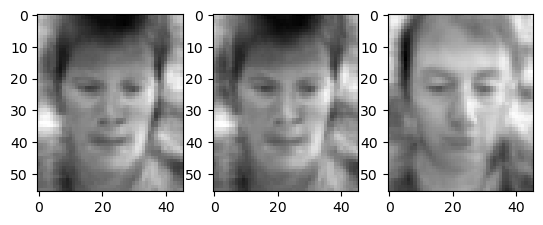

In [19]:
lda_ensemble = LDA_bagging()
lda_ensemble.fit(x_train, y_train)
lda_ensemble.predict(x_test)
lda_ensemble.evaluate(y_test)
lda_ensemble.reconstruction(x_test)